In [1]:
import duckdb, os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# Configuration and connection
DB_PATH = "D:/db/meta.duckdb"                 

con = duckdb.connect(DB_PATH)

con.execute("PRAGMA threads=2;") 
con.execute("SET memory_limit='5GB';") 
con.execute("SET preserve_insertion_order=false;") 

print("\n Set up ready")


 Set up ready


In [10]:
table_info = con.sql("""PRAGMA table_info(features.img_handcrafted_post)""").df()
print(table_info['name'].tolist())

['post_id', 'h_mean', 'h_std', 's_mean', 's_std', 'v_mean', 'v_std', 'h_hist_00', 'h_hist_01', 'h_hist_02', 'h_hist_03', 'h_hist_04', 'h_hist_05', 'h_hist_06', 'h_hist_07', 'h_hist_08', 'h_hist_09', 'h_hist_10', 'h_hist_11', 'h_hist_12', 'h_hist_13', 'h_hist_14', 'h_hist_15', 's_hist_00', 's_hist_01', 's_hist_02', 's_hist_03', 's_hist_04', 's_hist_05', 's_hist_06', 's_hist_07', 's_hist_08', 's_hist_09', 's_hist_10', 's_hist_11', 's_hist_12', 's_hist_13', 's_hist_14', 's_hist_15', 'v_hist_00', 'v_hist_01', 'v_hist_02', 'v_hist_03', 'v_hist_04', 'v_hist_05', 'v_hist_06', 'v_hist_07', 'v_hist_08', 'v_hist_09', 'v_hist_10', 'v_hist_11', 'v_hist_12', 'v_hist_13', 'v_hist_14', 'v_hist_15', 'gray_hist_00', 'gray_hist_01', 'gray_hist_02', 'gray_hist_03', 'gray_hist_04', 'gray_hist_05', 'gray_hist_06', 'gray_hist_07', 'gray_hist_08', 'gray_hist_09', 'gray_hist_10', 'gray_hist_11', 'gray_hist_12', 'gray_hist_13', 'gray_hist_14', 'gray_hist_15', 'laplacian_var', 'edge_density', 'entropy_gray', 'c

In [11]:
df = con.sql("""SELECT * FROM features.img_handcrafted_post""").df()

FloatProgress(value=0.0, layout=Layout(width='auto'), style=ProgressStyle(bar_color='black'))

In [ ]:
SUMMARY_COLS = [
    "colorfulness",
    "s_mean", "s_std",
    "v_mean", "v_std",
    "entropy_gray",
    "laplacian_var",
    "edge_density",
]

OUTDIR = "D:/figures"
os.makedirs(OUTDIR, exist_ok=True)

def _safe_series(df: pd.DataFrame, col: str) -> pd.Series:
    return (
        pd.to_numeric(df[col], errors="coerce")
        .replace([np.inf, -np.inf], np.nan)
        .dropna()
    )

df_plot = df.copy()

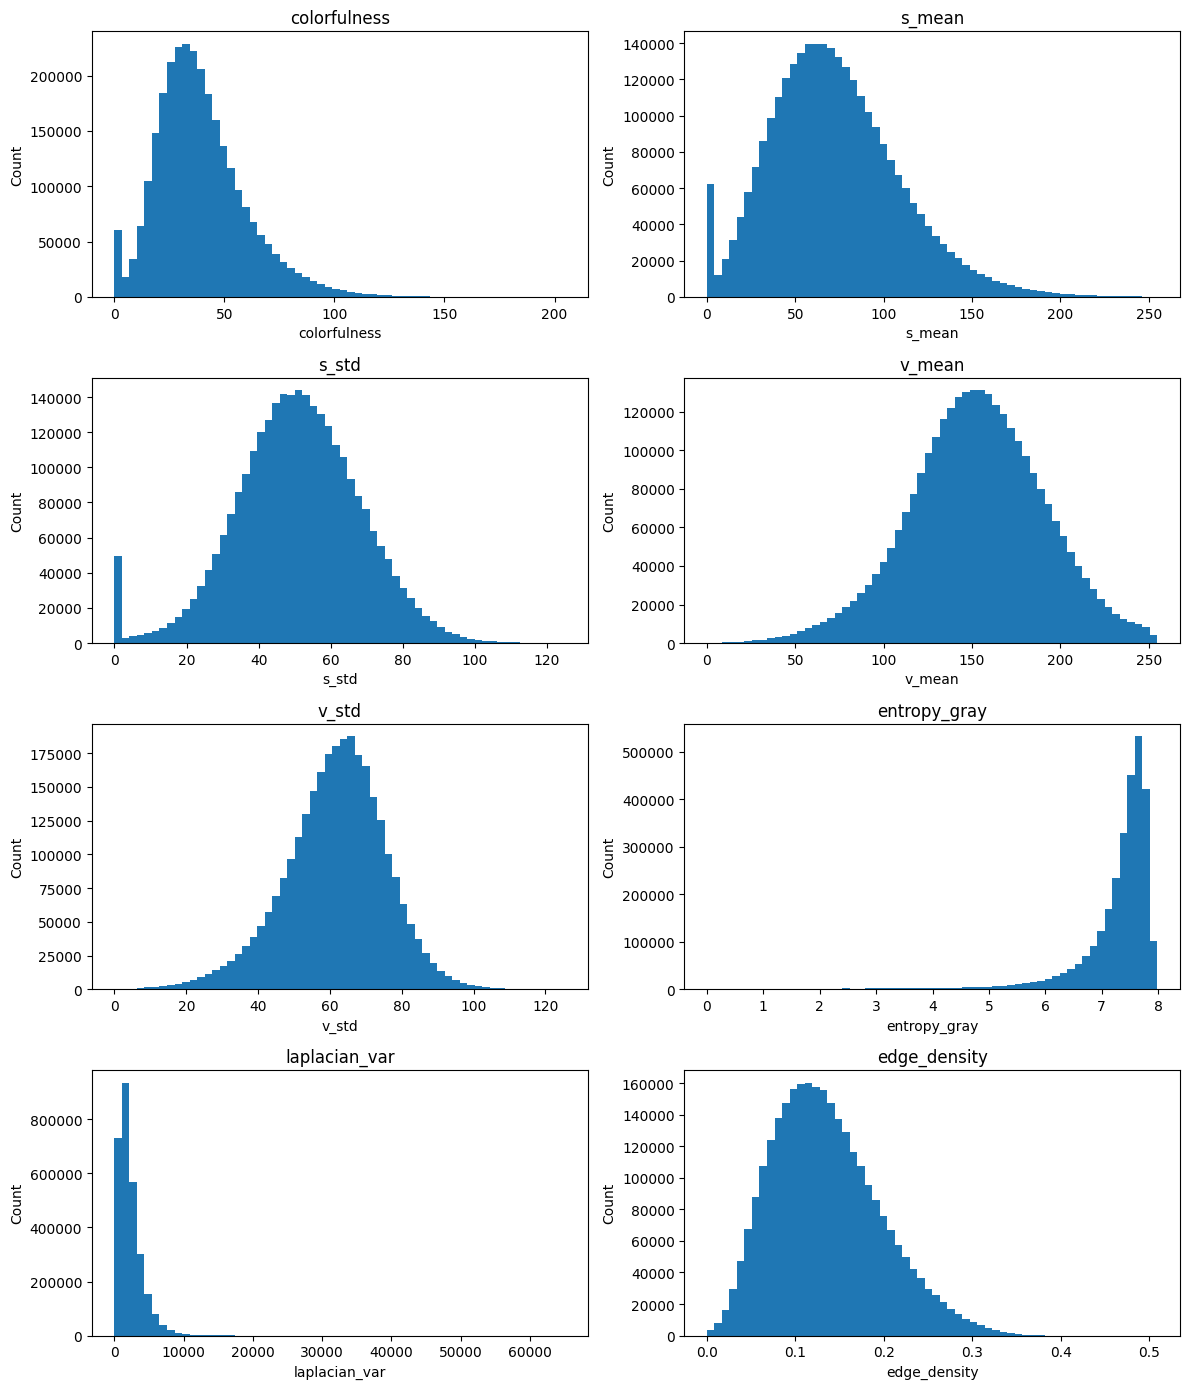

Saved: D:/figures\figA_summary_histograms.png


In [20]:
# Histogram of summary columns
fig, axes = plt.subplots(4, 2, figsize=(12, 14))
axes = axes.ravel()

for ax, col in zip(axes, SUMMARY_COLS):
    s = _safe_series(df_plot, col)
    ax.hist(s.values, bins=60)
    ax.set_title(col)
    ax.set_xlabel(col)
    ax.set_ylabel("Count")

for j in range(len(SUMMARY_COLS), len(axes)):
    axes[j].axis("off")

plt.tight_layout()
hist_path = os.path.join(OUTDIR, "figA_summary_histograms.png")
plt.savefig(hist_path, dpi=300, bbox_inches="tight")
plt.show()

print("Saved:", hist_path)

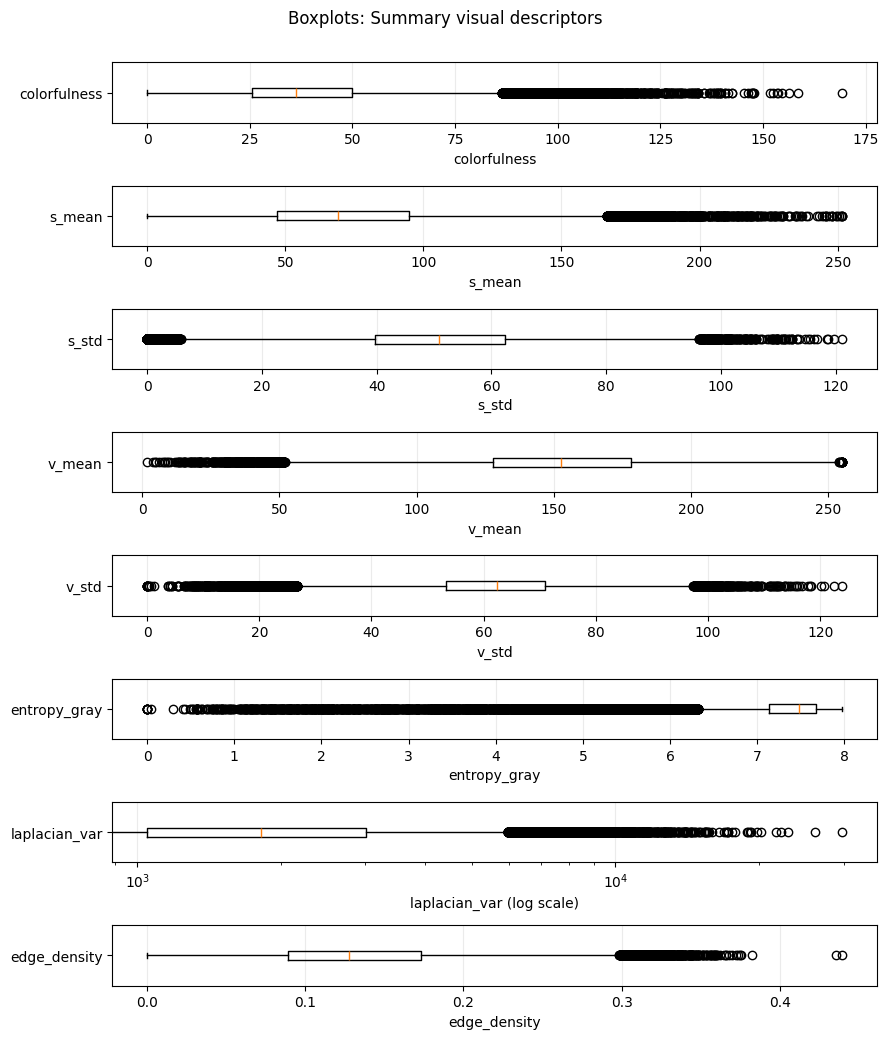

Saved to: D:/figures\figA_summary_boxplots_separate_scales.png


In [44]:
DF = df_plot  

SUMMARY_COLS = [
    "colorfulness",
    "s_mean","s_std",
    "v_mean","v_std",
    "entropy_gray",
    "laplacian_var",
    "edge_density"
]

def clean_col(df, col):
    s = pd.to_numeric(df[col], errors="coerce").dropna()
    return s.values

# Boxplots
fig, axes = plt.subplots(
    nrows=len(SUMMARY_COLS),
    ncols=1,
    figsize=(9, 1.3 * len(SUMMARY_COLS)),
    sharex=False
)

if len(SUMMARY_COLS) == 1:
    axes = [axes]

for ax, col in zip(axes, SUMMARY_COLS):
    x = clean_col(DF, col)

    ax.boxplot(x, vert=False, showfliers=True)
    ax.set_yticks([1])
    ax.set_yticklabels([col])
    ax.grid(True, axis="x", alpha=0.25)

    if col == "laplacian_var":
        ax.set_xscale("log")
        ax.set_xlabel(f"{col} (log scale)")
    else:
        ax.set_xlabel(col)

fig.suptitle("Boxplots: Summary visual descriptors", y=0.995)
plt.tight_layout(rect=[0, 0, 1, 0.99])

outpath = os.path.join(OUTDIR, "figA_summary_boxplots_separate_scales.png")
plt.savefig(outpath, dpi=300, bbox_inches="tight")
plt.show()

print("Saved to:", outpath)

In [49]:
df_er = con.sql("""
SELECT i.*, m.engagement_rate, er_bins, er_bins3, er_bins2
FROM features.img_handcrafted_post i JOIN md1718 m ON i.post_id = m.post_id""").df()

BIN_COL = "er_bins3"
SUMMARY_COLS = [
    "colorfulness",
    "s_mean", "s_std",
    "v_mean", "v_std",
    "entropy_gray",
    "laplacian_var",
    "edge_density",
]

dfp = df_er.replace([np.inf, -np.inf], np.nan).dropna(subset=[BIN_COL] + SUMMARY_COLS).copy()

# imposta ordine classi (se sono stringhe low/medium/high)
dfp[BIN_COL] = pd.Categorical(dfp[BIN_COL], categories=["low","medium","high"], ordered=True)

rows = []
for feat in SUMMARY_COLS:
    med_low  = float(np.median(dfp.loc[dfp[BIN_COL]=="low", feat].dropna().values))
    med_med  = float(np.median(dfp.loc[dfp[BIN_COL]=="medium", feat].dropna().values))
    med_high = float(np.median(dfp.loc[dfp[BIN_COL]=="high", feat].dropna().values))

    rows.append({
        "feature": feat,
        "median_low": med_low,
        "median_medium": med_med,
        "median_high": med_high,
        "delta_high_minus_low": med_high - med_low
    })

tbl_delta = pd.DataFrame(rows)

# ordina per differenza assoluta (così vedi subito le più "sensibili")
tbl_delta = tbl_delta.sort_values("delta_high_minus_low", key=lambda s: s.abs(), ascending=False)

tbl_delta

,feature,median_low,median_medium,median_high,delta_high_minus_low
6,laplacian_var,1904.000000,1811.000000,1757.000000,-147.000000
3,v_mean,155.125000,152.875000,150.375000,-4.750000
0,colorfulness,37.562500,36.062500,35.656250,-1.906250
2,s_std,51.812500,50.531250,50.156250,-1.656250
1,s_mean,70.187500,68.687500,68.812500,-1.375000
4,v_std,62.281250,62.375000,62.656250,0.375000
5,entropy_gray,7.457031,7.488281,7.492188,0.035156
7,edge_density,0.126099,0.128418,0.128418,0.002319
